## The task

Make predictions about the usefullness of a medicine kit for humans

- OBS.: ``Target``: 0 is usefull, 1 is not usefull

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.compose import ColumnTransformer

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import setuptools.dist
import tensorflow as tf
from tensorflow import keras

2025-01-23 09:57:00.708475: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 09:57:00.708970: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-23 09:57:00.711471: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-23 09:57:00.717646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737637020.728169   65960 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737637020.73

## Auxiliary functions

In [2]:
# Plot a single confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    ax = plt.subplot()
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, ax=ax, cmap="Blues", colorbar=False)
    plt.title("Confusion Matrix")
    ax.grid(False)

In [3]:
# Print feature importances in descending order
def print_feature_importances(features, model):
    if isinstance(model, BayesSearchCV):
        model_name = model.best_estimator_.steps[-1][0]
        feat_imp_values = model.best_estimator_.named_steps[model_name]
    elif isinstance(model, Pipeline):
        model_name = model.steps[-1][0]
        feat_imp_values = model.named_steps[model_name]
    importance = pd.DataFrame({
        "feature": features,
        "importance": feat_imp_values.feature_importances_
    }).sort_values("importance", ascending=False)
    print("\
          Feature Importance:")
    print(importance)

In [4]:
# Cross validation results
def cross_val_results(estimator, X, y, cv, scoring):
    results = cross_validate(estimator=estimator, X=X, y=y, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"Mean precision: {results['test_precision'].mean()}")
    print(f"Mean recall: {results['test_recall'].mean()}")
    print(f"Mean f1-score: {results['test_f1'].mean()}")    

## Loading data

In [5]:
df_train = pd.read_csv(filepath_or_buffer="../data/raw/train.csv")
df_test = pd.read_csv(filepath_or_buffer="../data/raw/test.csv")

In [6]:
df_train.head()

,ID,Distributor,Product,Duration,Destination,Sales,Commission,Gender,Age,Target
0,fffe3800370038003900,7,1,22,122,31.0,0.00,NaN,20,0
1,fffe34003200370037003500,7,1,26,52,22.0,0.00,NaN,36,0
2,fffe32003100320030003200,7,10,15,83,63.0,0.00,NaN,34,0
3,fffe34003400310037003000,8,25,24,55,62.0,24.80,0.0,118,0
4,fffe32003400390038003000,6,16,12,122,19.8,11.88,NaN,26,0


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6736 entries, 0 to 6735
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           6736 non-null   object 
 1   Distributor  6736 non-null   int64  
 2   Product      6736 non-null   int64  
 3   Duration     6736 non-null   int64  
 4   Destination  6736 non-null   int64  
 5   Sales        6736 non-null   float64
 6   Commission   6736 non-null   float64
 7   Gender       2032 non-null   float64
 8   Age          6736 non-null   int64  
 9   Target       6736 non-null   int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 526.4+ KB


In [8]:
df_test.head()

,ID,Distributor,Product,Duration,Destination,Sales,Commission,Gender,Age
0,fffe31003600330038003500,6,16,8,60,69.30,41.58,NaN,51
1,fffe33003600300031003400,2,4,368,112,161.00,40.25,0.0,51
2,fffe320033003300,2,4,387,112,291.75,72.94,0.0,51
3,fffe390039003800,7,10,4,25,18.00,0.00,NaN,36
4,fffe3500350031003000,11,20,40,59,39.50,25.68,0.0,38


In [9]:
# Looking for missing values
df_train.isna().sum()

ID                0
Distributor       0
Product           0
Duration          0
Destination       0
Sales             0
Commission        0
Gender         4704
Age               0
Target            0
dtype: int64

In [10]:
# Lookingo for duplicated entries
df_train.duplicated().sum()

np.int64(0)

<Axes: xlabel='Target', ylabel='count'>

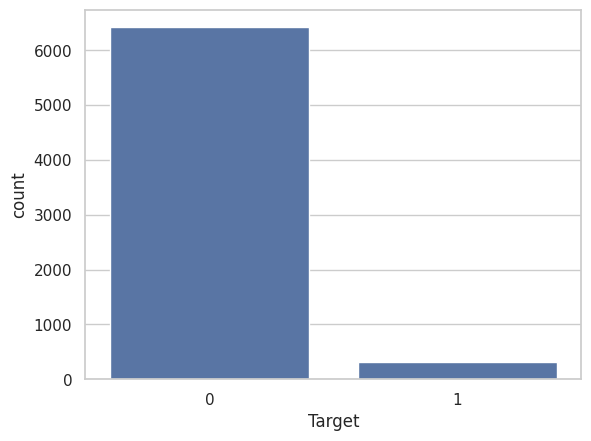

In [11]:
# Target distribution
sns.countplot(data=df_train, x=df_train["Target"])

In [12]:
df_train["Target"].value_counts(normalize=True)

Target
0    0.953088
1    0.046912
Name: proportion, dtype: float64

In [13]:
# Descriptive statistics
df_train.describe()

# Max Age value is strange
# Min Sales negative?
# Min Duration negative?

,Distributor,Product,Duration,Destination,Sales,Commission,Gender,Age,Target
count,6736.000000,6736.00000,6736.000000,6736.000000,6736.000000,6736.000000,2032.000000,6736.000000,6736.000000
mean,6.563539,9.40380,51.588034,81.681413,42.802316,10.469831,0.512795,39.880344,0.046912
std,2.440587,6.62581,79.504738,39.530726,52.408053,20.342999,0.499959,13.872811,0.211466
min,0.000000,0.00000,-1.000000,0.000000,-277.200000,0.000000,0.000000,1.000000,0.000000
25%,6.000000,2.00000,10.000000,55.000000,18.000000,0.000000,0.000000,35.000000,0.000000
50%,7.000000,10.00000,23.000000,86.000000,28.000000,0.000000,1.000000,36.000000,0.000000
75%,7.000000,16.00000,54.000000,112.000000,49.500000,11.880000,1.000000,44.000000,0.000000
max,15.000000,25.00000,444.000000,139.000000,666.000000,262.760000,1.000000,118.000000,1.000000


<Axes: xlabel='Age'>

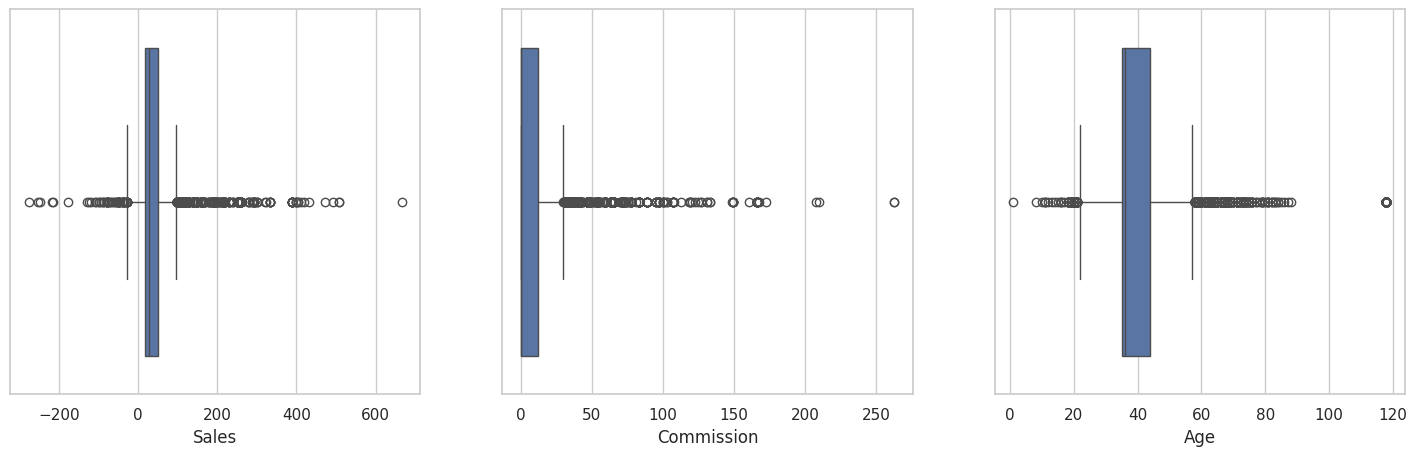

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
sns.boxplot(data=df_train, x=df_train["Sales"], ax=ax[0])
sns.boxplot(data=df_train, x=df_train["Commission"], ax=ax[1])
sns.boxplot(data=df_train, x=df_train["Age"], ax=ax[2])

In [15]:
df_train[df_train["Age"] > 100]["Age"].unique()

array([118])

In [16]:
# Remove coluns with Age = 118
df_train = df_train[df_train["Age"] != 118]

In [17]:
df_train[df_train["Age"] > 100]

,ID,Distributor,Product,Duration,Destination,Sales,Commission,Gender,Age,Target


In [18]:
# Negative Sales
df_train[df_train["Sales"] < 0]

,ID,Distributor,Product,Duration,Destination,Sales,Commission,Gender,Age,Target
12,fffe34003100300038003100,6,16,35,78,-19.80,11.88,NaN,37,0
40,fffe34003400340035003200,6,16,27,4,-79.20,47.52,NaN,34,0
58,fffe3100300030003300,6,16,65,60,-79.20,47.52,NaN,45,0
68,fffe32003500320037003400,2,17,309,112,-53.25,13.31,1.0,37,0
250,fffe31003400300038003800,2,9,5,112,-13.50,3.38,0.0,31,0
...,...,...,...,...,...,...,...,...,...,...
5982,fffe31003800390031003600,6,16,166,112,-29.70,17.82,NaN,31,0
6240,fffe32003900330037003000,6,16,12,4,-89.10,53.46,NaN,59,0
6394,fffe32003200300030003800,6,16,75,58,-29.70,17.82,NaN,32,0
6425,fffe33003700320039003000,6,16,25,4,-79.20,47.52,NaN,61,0


In [19]:
# Remove negative Sales
df_train = df_train[df_train["Sales"] > 0]

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6365 entries, 0 to 6735
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           6365 non-null   object 
 1   Distributor  6365 non-null   int64  
 2   Product      6365 non-null   int64  
 3   Duration     6365 non-null   int64  
 4   Destination  6365 non-null   int64  
 5   Sales        6365 non-null   float64
 6   Commission   6365 non-null   float64
 7   Gender       1895 non-null   float64
 8   Age          6365 non-null   int64  
 9   Target       6365 non-null   int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 547.0+ KB


In [21]:
# Spliting df_train into X and y(target)
X_train = df_train.drop(columns="Target")
y_train = df_train["Target"].copy()

In [22]:
# Split into train and validation dataframes
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [23]:
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))

Target
0    0.9511
1    0.0489
Name: proportion, dtype: float64
Target
0    0.951296
1    0.048704
Name: proportion, dtype: float64


In [24]:
# Selected features ==> Gender will not be used as a predictive feature for two reasons: a) ethics; b) most of the values are NaN
features = X_train.columns.drop(["ID", "Gender"])
features

Index(['Distributor', 'Product', 'Duration', 'Destination', 'Sales',
       'Commission', 'Age'],
      dtype='object')

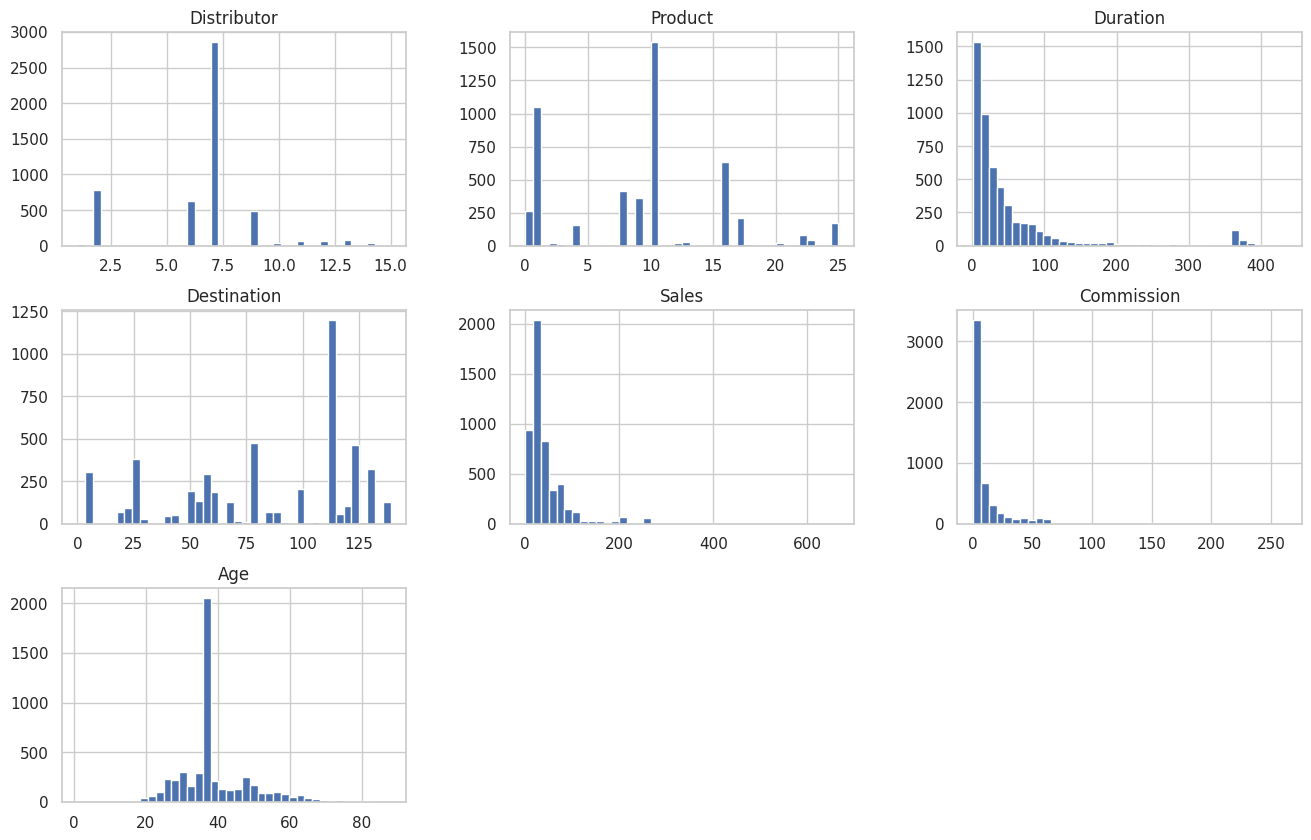

In [25]:
X_train[features].hist(bins=40, figsize=(16,10));

## Model training

### Rescale

In [26]:
#X_train["Sales"] = X_train["Sales"].transform(np.log1p)

rescaler = ColumnTransformer(
    transformers=[
        ("std_scaler", StandardScaler(), features)
        #("std_scaler", StandardScaler(), ['Distributor', 'Product', 'Destination', 'Sales', 'Age', "Commission"]),
        #("pwr_scaler", PowerTransformer(method="yeo-johnson"), ["Duration"])
    ]
)

### Random Forest

In [27]:
# Pipeline
rf_clf = Pipeline([
    ("rescaler", rescaler),
    ("model", RandomForestClassifier(random_state=42))
])

In [28]:
# Bayesian search
rf_space = {
    "model__n_estimators": Integer(100, 1000),
    "model__criterion": ["gini", "entropy", "log_loss"],
    "model__max_depth": Integer(2, 10),
    "model__class_weight": [None, "balanced", "balanced_subsample"],
    "model__max_features": ["sqrt", "log2"],
    "model__min_impurity_decrease": Real(0.001, 0.1, prior="log-uniform")
}

rf_clf_opt = BayesSearchCV(estimator=rf_clf, search_spaces=rf_space, scoring="f1", cv=5, random_state=42, n_jobs=-1)

In [29]:
rf_clf_opt.fit(X=X_train[features], y=y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('rescaler',
                                         ColumnTransformer(transformers=[('std_scaler',
                                                                          StandardScaler(),
                                                                          Index(['Distributor', 'Product', 'Duration', 'Destination', 'Sales',
       'Commission', 'Age'],
      dtype='object'))])),
                                        ('model',
                                         RandomForestClassifier(random_state=42))]),
              n_jobs=-1, random_state=42, scoring='f1',
              search_spaces={'model__class_weight...
                             'model__criterion': ['gini', 'entropy',
                                                  'log_loss'],
                             'model__max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'model__max_features': ['sqrt', 'log2'],
                             'model__min_impurity_decrease': Real(low=0.001, high=0.1, prior='log-uniform', transform='normalize'),
                             'model__n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize')})

In [30]:
cross_val_results(estimator=rf_clf_opt, X=X_train[features], y=y_train, cv=5, scoring=["precision", "recall", "f1"])

Mean precision: 0.1986452279689904
Mean recall: 0.6026122448979592
Mean f1-score: 0.2981394193120336


In [127]:
rf_clf_opt

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('rescaler',
                                         ColumnTransformer(transformers=[('std_scaler',
                                                                          StandardScaler(),
                                                                          Index(['Distributor', 'Product', 'Duration', 'Destination', 'Sales',
       'Commission', 'Age'],
      dtype='object'))])),
                                        ('model',
                                         RandomForestClassifier(random_state=42))]),
              n_jobs=-1, random_state=42, scoring='f1',
              search_spaces={'model__class_weight...
                             'model__criterion': ['gini', 'entropy',
                                                  'log_loss'],
                             'model__max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'model__max_features': ['sqrt', 'log2'],
                             'model__min_impurity_decrease': Real(low=0.001, high=0.1, prior='log-uniform', transform='normalize'),
                             'model__n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize')})

In [31]:
y_pred_rf = rf_clf_opt.predict(X=X_val[features])

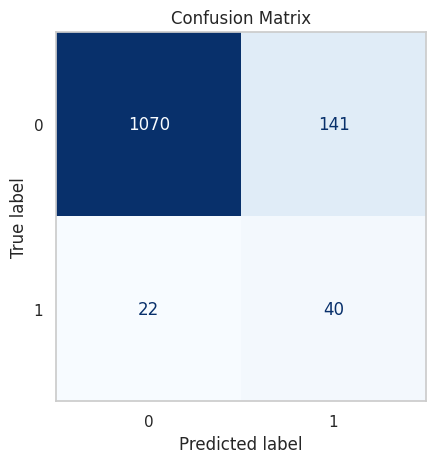

In [32]:
plot_confusion_matrix(y_true=y_val, y_pred=y_pred_rf)

In [33]:
print(classification_report(y_pred=y_pred_rf, y_true=y_val, digits=4))

              precision    recall  f1-score   support

           0     0.9799    0.8836    0.9292      1211
           1     0.2210    0.6452    0.3292        62

    accuracy                         0.8720      1273
   macro avg     0.6004    0.7644    0.6292      1273
weighted avg     0.9429    0.8720    0.9000      1273



In [34]:
print_feature_importances(features=features, model=rf_clf_opt)

          Feature Importance:
       feature  importance
0  Distributor    0.204802
2     Duration    0.173512
4        Sales    0.160041
5   Commission    0.158767
3  Destination    0.127025
6          Age    0.107944
1      Product    0.067909


### HGBoost

In [35]:
hgb_clf = Pipeline([
    ("rescaler", rescaler),
    ("model", HistGradientBoostingClassifier())
])

In [36]:
hgb_space = {
    "model__learning_rate": Real(0.001, 1, prior="log-uniform"),
    "model__l2_regularization": Real(0.001, 1, prior="log-uniform"),
    "model__max_features": Real(0.1, 1),
    "model__min_samples_leaf": Integer(10, 20),
    "model__class_weight": [None, "balanced"]
}

hgb_clf_opt = BayesSearchCV(estimator=hgb_clf, search_spaces=hgb_space, scoring="f1", cv=5, random_state=42, n_jobs=-1)

In [37]:
hgb_clf_opt.fit(X=X_train[features], y=y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('rescaler',
                                         ColumnTransformer(transformers=[('std_scaler',
                                                                          StandardScaler(),
                                                                          Index(['Distributor', 'Product', 'Duration', 'Destination', 'Sales',
       'Commission', 'Age'],
      dtype='object'))])),
                                        ('model',
                                         HistGradientBoostingClassifier())]),
              n_jobs=-1, random_state=42, scoring='f1',
              search_spaces={'model__class_weight': [None...
                             'model__l2_regularization': Real(low=0.001, high=1, prior='log-uniform', transform='normalize'),
                             'model__learning_rate': Real(low=0.001, high=1, prior='log-uniform', transform='normalize'),
                             'model__max_features': Real(low=0.1, high=1, prior='uniform', transform='normalize'),
                             'model__min_samples_leaf': Integer(low=10, high=20, prior='uniform', transform='normalize')})

In [38]:
def cross_val_results(estimator, X, y, cv, scoring):
    results = cross_validate(estimator=estimator, X=X, y=y, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"Mean precision: {results['test_precision'].mean()}")
    print(f"Mean recall: {results['test_recall'].mean()}")
    print(f"Mean f1-score: {results['test_f1'].mean()}")    

In [39]:
cross_val_results(estimator=hgb_clf_opt, X=X_train[features], y=y_train, cv=5, scoring=["precision", "recall", "f1"])

Mean precision: 0.1810375340964247
Mean recall: 0.6551836734693877
Mean f1-score: 0.28361824903369837


In [40]:
y_pred_hgb = hgb_clf_opt.predict(X=X_val)

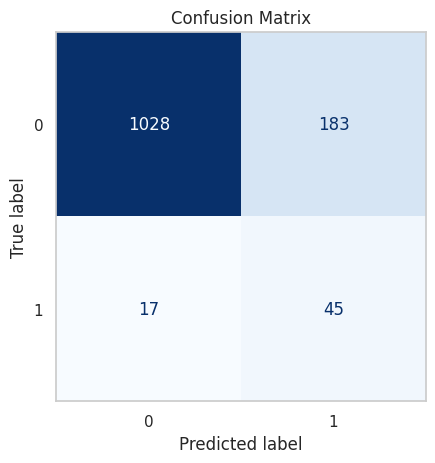

In [41]:
plot_confusion_matrix(y_true=y_val, y_pred=y_pred_hgb)

In [42]:
print(classification_report(y_true=y_val, y_pred=y_pred_hgb, digits=4))

              precision    recall  f1-score   support

           0     0.9837    0.8489    0.9113      1211
           1     0.1974    0.7258    0.3103        62

    accuracy                         0.8429      1273
   macro avg     0.5906    0.7873    0.6108      1273
weighted avg     0.9454    0.8429    0.8821      1273



### Neural Network

- Input format should be an numpy array

In [27]:
#X_train_tf = rescaler.fit_transform(X_train[features])
X_train_tf = X_train[features].values

In [30]:
X_train_tf.shape[1:]

(7,)

In [31]:
y_train_tf = y_train.values

In [38]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

tf_clf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X_train_tf.shape[1:]),
    tf.keras.layers.Normalization(), 
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=16, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

In [39]:
tf_clf.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 7)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,840 (179.07 KB)

 Trainable params: 45,825 (179.00 KB)

 Non-trainable params: 15 (64.00 B)

In [76]:
#tf.keras.utils.plot_model(tf_clf, "my_fashion_mnist_model.png", show_shapes=True, dpi=80)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [48]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
tf_clf.compile(loss="binary_crossentropy",
               optimizer=optimizer,
               metrics=["recall"])

In [49]:
#norm_layer.adapt(X_train[features])
tf_clf.fit(x=X_train_tf, y=y_train_tf, epochs=30, batch_size=64)

Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1377 - recall: 0.0313      
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 0.1327 - recall: 0.0619 
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1323 - recall: 0.0715   
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.1381 - recall: 0.0379 
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 0.1326 - recall: 0.0375 
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 0.1346 - recall: 0.0614 
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 0.1316 - recall: 0.0798 
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 0.1414 - recall: 0.0463 
Epoch 9/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1565 - recall: 0.0402   
Epoch 10/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1716 - recall: 0.0140   
Epoch 11/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.1501 - recall: 0.0146 
Epoch 12/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss:

In [55]:
X_val_tf = X_val[features].values
y_val_tf = y_val.values

array([0, 1, 0, ..., 0, 0, 0])

### Linear Regression